# Optimization of L4/3 Photonic Crystal

In [1]:
import numpy as np
from chickpea.cma import CavityModeAnalysis
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

#Cavity simulation in Chikpea
In the Legume tutorial
[Guided_mode_expansion_with_autograd](../docs/examples/06_Guided_mode_expansion_with_autograd.ipynb).
A L4/3 crystal is optimized for Q factor and modal volume of a particular mode. The mode analyzed in this tutorial
is chosen with prior knowledge of the mode structure. For novel crystals the mode structure may not be known in advance.

How can we close the loop on what we learned in
[Analyzing an H2 Photonic Crystal Cavity](02_Analyzing_an_H2_Photonic_Crystal_Cavity.ipynb)
to determine which mode is appropriate to optimize without any previous knowledge of the mode structure?


In [2]:
# Number of PhC periods in x and y directions
Nx, Ny = 16, 10

# Regular PhC parameters
ra = 0.234
dslab = 0.4355
n_slab = 2.21

# Initialize a lattice and PhC
lattice = legume.Lattice([Nx, 0], [0, Ny*np.sqrt(3)/2])

# Make x and y positions in one quadrant of the supercell
# We only initialize one quadrant because we want to shift the holes symmetrically
xp, yp = [], []
nx, ny = Nx//2 + 1, Ny//2 + 1
for iy in range(ny):
    for ix in range(nx):
        xp.append(ix + (iy%2)*0.5)
        yp.append(iy*np.sqrt(3)/2)

# Move the first two holes to create the L4/3 defect
xp[0] = 2/5
xp[1] = 6/5
nc = len(xp)

0.0


In [3]:
# Define L4/3 PhC cavity with shifted holes
def cavity(dx, dy):
    # Initialize PhC
    phc = legume.PhotCryst(lattice)

    # Add a layer to the PhC
    phc.add_layer(d=dslab, eps_b=n_slab**2)

    # Apply holes symmetrically in the four quadrants
    for ic, x in enumerate(xp):
        yc = yp[ic] if yp[ic] == 0 else yp[ic] + dy[ic]
        xc = x if x == 0 else xp[ic] + dx[ic]
        phc.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=ra))
        if nx-0.6 > xp[ic] > 0 and (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=-yc, r=ra))
        if nx-1.6 > xp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=yc, r=ra))
        if (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0 and nx-1.1 > xp[ic]:
            phc.add_shape(legume.Circle(x_cent=xc, y_cent=-yc, r=ra))

    return phc

From here we diverge. What do the modes of the L4/3 Crystal look like? Applying the same techniques as in
[Analyzing an H2 Photonic Crystal Cavity](02_Analyzing_an_H2_Photonic_Crystal_Cavity.ipynb)

We initialize the cavity with zero displacement.


In [4]:
# Initialize shift parameters to zeros
dx, dy = np.zeros((nc,)), np.zeros((nc,))

phc = cavity(dx, dy)

a1 = np.array([0.5, np.sqrt(3)/2])
a2 = np.array([0.5, -np.sqrt(3)/2])

base_lattice = legume.Lattice(a1,a2)
base_phc = legume.PhotCryst(base_lattice)
base_phc.add_layer(d=dslab, eps_b=n_slab**2)
base_phc.layers[0].add_shape(legume.Circle(eps=1.0, r=ra))

defect_margins = np.array([0.25,0.25])
cma = CavityModeAnalysis(phc, base_phc, defect_margins, layer=0, gmax=2, base_gmax=3)

0.5


Where are the band gaps of this crystal?

<AxesSubplot:xlabel='Wave vector', ylabel='Frequency'>

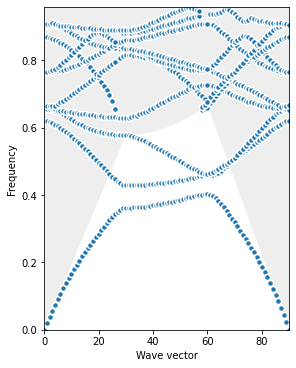

In [5]:
band_gaps, k_air, k_eps =cma.find_band_gaps(band_tol=0.025,
                                            order=np.array([0,2]), # The order of modes that we care about.
                                                                   # TE modes are numbers [0,2,4,6,8]
                                                                   # We happen to know that higher order modes are
                                                                   # well above the bandgap
                                            trim_lc=False,
                                            lc_trim=0, # The lc-trim parameter governs how close to the light cone
                                            numeig=10, sample_rate=30)

gmg_ratio = np.array([(band_gap[1] - band_gap[0]) / band_gap[2] for band_gap in band_gaps])

legume.viz.bands(cma.base_gme,  trim_light_cone=False, lc_trim=0)

In [6]:
# There is only one band-gap for this crystal with properties.
print("Band gap lower bound: %f.\n"
      "Band gap upper bound: %f.\n"
      "Band gap center: %f.\n"
      "Gap-midgap ratio: %f.\n"
      "The top of the air band is at k= (%f, %f).\n"
      "The bottom of the dielectric band is at k= (%f, %f).\n" %  (band_gaps[0][0],
                                                                   band_gaps[0][1],
                                                                   band_gaps[0][2],
                                                                   gmg_ratio[0], k_air[0], k_air[1],
                                                                   k_eps[0], k_eps[1]))

Band gap lower bound: 0.402868.
Band gap upper bound: 0.429419.
Band gap center: 0.416144.
Gap-midgap ratio: 0.063803.
The top of the air band is at k= (3.141593, 1.813799).
The bottom of the dielectric band is at k= (4.188790, 0.000000).



Analyzing the modes around this point we run

In [7]:
options = {'verbose': True,
           'gmode_inds': [0],
           'gradients': 'approx',
           'numeig': 200,
           'eig_solver': 'eigh',
           'eig_sigma': band_gaps[0][2],
           'compute_im': False
        }

cma.gme.run(kpoints=np.array([[0],[0]]), **options)

20.8119s total time for real part of frequencies, of which
  0.2190s for guided modes computation using the gmode_compute='exact' method
  0.3850s for inverse matrix of Fourier-space permittivity
  16.2149s for matrix diagionalization using the 'eigh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes


Because we simulated outside the light cone we can filter cavity modes by
restricting the frequency range to the band gap and filtering off high mode volume modes.

In [10]:
arg_list, v = cma.mode_volume_filter(max_volume=10, band_filter=[band_gaps[0]])

In [11]:
q=[]
freqs_im=[]
rad_coup=[]
rad_gvec=[]
for kind, mlist in enumerate(arg_list):
    freqs_im_list, rad_coup_list, rad_gvec_list = cma.gme.compute_rad(kind=kind, minds=mlist)
    qlist = cma.gme.freqs[kind][mlist]/(2*freqs_im_list)
    q.append(qlist)
    freqs_im.append(freqs_im_list)
    rad_coup.append(rad_coup_list)
    rad_gvec.append(rad_gvec_list)

Finally, knowing the mode volume and the Q factor of our we plot the magnitude of the electric fields

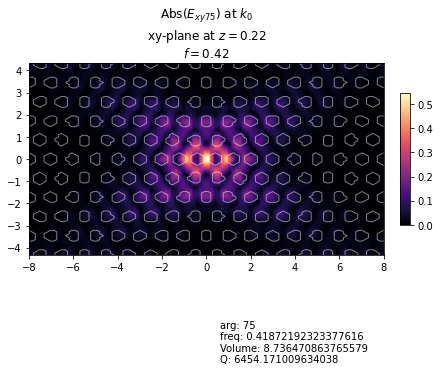

In [12]:
for kind, mlist in enumerate(arg_list):
    for i, mind in enumerate(mlist):
        fig=legume.viz.field(cma.gme,'E', kind, mind, z=dslab/2, component='xy', val='abs', N1=100, N2=100, norm=True)
        fig.text(0.5,-0.25,
                 "arg: " + str(mind)+ "\n"
                 + "freq: " + str(cma.gme.freqs[kind][mind]) + "\n"
                 + "Volume: " + str(v[kind][i]) + "\n"
                 + "Q: " + str(q[kind][i]))
